In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [39]:
image_dir = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/train_data'
label_file = '/Users/shreyasmishra/Documents/MLCode/CV/Project Task 1/train_labels.txt'

In [40]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in sorted(os.listdir(image_dir)) if f.endswith('.jpg')]  
        self.labels = self.load_labels(label_file)
    
    def load_labels(self, label_file):
        with open(label_file, 'r') as f:
            labels = [int(line.strip()) for line in f]  
        return labels
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [41]:
dataset = ImageDataset(image_dir=image_dir, label_file=label_file, transform=transforms.ToTensor())

In [42]:
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)


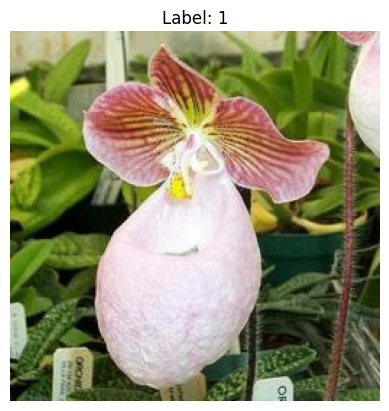

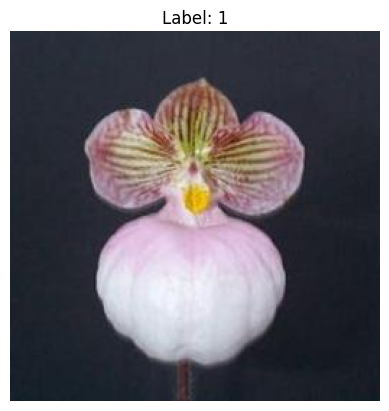

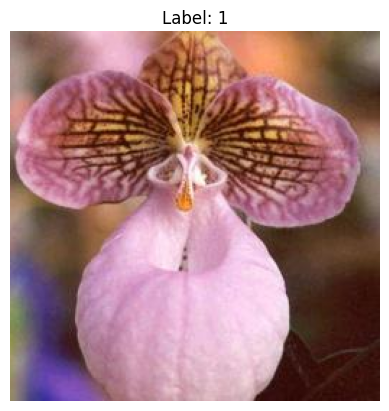

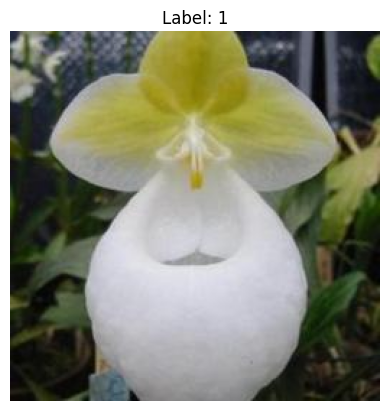

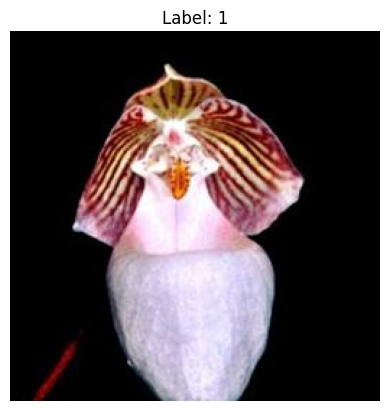

In [43]:
for images, labels in dataloader:
    # Convert the first 5 images back to PIL images and display them
    for i in range(5):  # Display 5 images
        img = transforms.ToPILImage()(images[i])  # Convert tensor to PIL image
        plt.figure()
        plt.title(f'Label: {labels[i].item()}')  # Display the label
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
    break

In [44]:
print(dataset.image_filenames)

['01_image_05087.jpg', '01_image_05088.jpg', '01_image_05089.jpg', '01_image_05090.jpg', '01_image_05091.jpg', '01_image_05092.jpg', '01_image_05093.jpg', '01_image_05094.jpg', '01_image_05095.jpg', '01_image_05096.jpg', '01_image_05097.jpg', '01_image_05098.jpg', '01_image_05099.jpg', '01_image_05100.jpg', '01_image_05101.jpg', '01_image_05102.jpg', '01_image_05103.jpg', '01_image_05104.jpg', '01_image_05105.jpg', '01_image_05106.jpg', '01_image_05107.jpg', '01_image_05108.jpg', '01_image_05109.jpg', '01_image_05110.jpg', '01_image_05111.jpg', '01_image_05112.jpg', '01_image_05113.jpg', '01_image_05114.jpg', '01_image_05115.jpg', '01_image_05116.jpg', '01_image_05117.jpg', '01_image_05118.jpg', '01_image_05119.jpg', '01_image_05120.jpg', '01_image_05121.jpg', '01_image_05122.jpg', '01_image_05123.jpg', '01_image_05124.jpg', '01_image_05125.jpg', '01_image_05126.jpg', '01_image_05127.jpg', '01_image_05128.jpg', '01_image_05129.jpg', '01_image_05130.jpg', '01_image_05131.jpg', '01_image